# Model: Interests (Topic Modeling)

* This model uses NLP to determine similar interests between users.

**Methodology for finding similar interests (clustering / NLP):**
* Join all reviews for each user as one document per user
* Process and clean text
* Do Bag-of-Words (bigram and trigram) for each document
* Do LDA
* K-means cluster training set according to their LDA per-document topic distribution
* Assign test set to a cluster based on their LDA per-document topic distribution

**Methodology for recommendation:**
* For each K-means cluster of the training set, find the 10 most popular restaurants in SG according to number of people who have visited.
* For each user in the test set, when they are assigned a cluster, give them the recommendations according to the training set.

**Accuracy measurement:**
* If a user has visited at least one restaurant in the recommendation list, then model is counted as correct.

## Data Prep

Read in data and split it into test/train.

In [75]:
import pickle
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import gensim
from gensim import corpora, models
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import spacy
from gensim.models.phrases import Phrases, Phraser
import matplotlib.pyplot as plt

In [2]:
# importing SG restaurant names

food = pd.read_csv("data/food.csv")
restaurants = pd.read_csv("data/restaurants.csv")

# combine and remove duplicates

business = pd.concat([food,restaurants])

business = business.drop_duplicates(subset = 'id', keep = 'first').name.unique()

business[0:5]

array(['Tian Tian Hainanese Chicken Rice', 'Maxwell Food Centre',
       'Jumbo Seafood', 'Song Fa Bak Kut Teh 松發 肉骨茶',
       'Lau Pa Sat Festival Market'], dtype=object)

In [3]:
# read in reviews

datafile = open("reviews.pkl", "rb")

df_reviews = pickle.load(datafile)
datafile.close()

df_reviews.head()

,business_address,business_id,business_name,cool,funny,rating,review_id,singapore_flag,text,useful,user_id
0,"54 Shoreline CirIncline Village, NV 89451",WChhuvV8Kc8xwLZiQkik4A,Daisy Day Care,0,0,5.0,Qvltfxy80b_147zraCbBGQ,0,I used Daisy Day Care last Friday with my 1 ye...,0,LkyT0hPUs_47mCtS4MQs3Q
1,"3821 N Narragansett AveChicago, IL 60634",g591dkunZTWfij-y85AFsw,Echo Limousine,1,1,5.0,eINK_4WAslLZULaKbNicVw,0,We recently used Echo Limousine to get from th...,1,LkyT0hPUs_47mCtS4MQs3Q
2,Calle los Palmitos 335290 San Bartolome de Tir...,LxhCSu0FvnDjiotkMzf53A,Aqualand Maspalomas,1,0,2.0,ppwQaxai_Ewb97J3KKwQhQ,0,Short story: this is a water park. That means ...,0,LkyT0hPUs_47mCtS4MQs3Q
3,"Avenida Los Canarios, 2735120 ArguineguinSpain",np0BG0KgxSu--e6NX7Aymw,Restaurant Valentino,0,0,5.0,S7xBOJqnNG4vPN8n2HaNJg,0,We had a really nice dinner here last night. T...,0,LkyT0hPUs_47mCtS4MQs3Q
4,"4134 Geary BlvdSan Francisco, CA 94118",_BzWIbtbJV5gzqEbZ2DjPg,Overtime Sports Bar & Restaurant - CLOSED,2,0,5.0,HizKwTg4v4R5xc5fznkeDQ,0,Awesome spot! Much needed addition to the neig...,0,LkyT0hPUs_47mCtS4MQs3Q


In [4]:
# filtering out any users who don't have reviews
userswithreview = list(df_reviews.user_id.unique())

In [5]:
# read in users
datafile = open("user_info.pkl", "rb")

df_user = pickle.load(datafile)
datafile.close()

df_user = df_user[df_user.user_id.isin(userswithreview)]

df_user.head()

,elite_status,friend_count,friends,location,name,review_count,user_id
0,0.0,57.0,"[LZmKJIj_EVyrspkpII7stg, y0DE2C7GwxYU9gOIlj69V...","Geylang, Singapore, Singapore",Paul L.,4.0,ccROBnsVV5E1jxBfr7XReg
1,1.0,10.0,"[0wBI9RiVyf9HnL1IuGCCUw, cU7ysY41qGppbw4pQgjqg...","Boston, MA",Christine W.,39.0,kMGE7cs1qQAIr2gyQMmWkQ
2,1.0,140.0,"[-nQfkQuRfX2qLX-3gbgX9g, GHkLufp4_N6pwyGR9PRAm...","San Jose, CA",Ellen S.,339.0,PK4F1LiBh_x1LPbTMFmByw
3,0.0,2.0,"[L0Sq7gVgSlwGuxxAFwNmjA, Uce419ATf8Ytal3lUpmjMQ]","South Loop, Chicago, IL",Michelle N.,28.0,MszVzakDJlDQNRPDUZMtXg
4,0.0,101.0,"[3VSljYsKVX8oWSHR3HuH3Q, ChSHPHX2RMIvj2lKhM6C3...","Singapore, Singapore","Camy ""gimmycamy"" T.",142.0,W8vFfu8VMe9EAhDcphjDuQ


In [6]:
#split singaporean nonsingaporean

df_local = df_user[df_user['location'].str.contains("Singapore")]

df_tourist = df_user[~df_user['location'].str.contains("Singapore")]

print("%d locals and %d foreigners" % (len(df_local), len(df_tourist)))

380 locals and 1165 foreigners


In [7]:
tourist_ids = df_tourist['user_id'].values

train_ids, test_ids = train_test_split(tourist_ids, test_size = 0.3, random_state = 0)

print("Test set has %d ids and train set has %d" % (len(test_ids), len(train_ids)))

Test set has 350 ids and train set has 815


In [98]:
# train IDs and singapore IDs

train_ids_full = list(df_local['user_id']) + list(train_ids)

print("Full train set: %d" % len(train_ids_full))

Full train set: 1195


## NLP Text Processing

In [54]:
# prepare text for NLP
df_reviews_process = df_reviews[['user_id', 'singapore_flag', 'text']]

df_reviews_process = df_reviews_process[~((df_reviews_process['user_id'].isin(test_ids)) & (df_reviews_process['singapore_flag'] == 1))]

In [55]:
# filter out any test ids that only left reviews in singapore

filtertest = set(userswithreview) - set(df_reviews_process.user_id.values)
filtertest = list(filtertest)

test_ids = [x for x in test_ids if x not in filtertest]

len(test_ids)

337

In [56]:
# last n reviews of each user

n=50
#s=df_reviews_process.groupby('user_id').text.transform('count')

df_reviews_process = df_reviews_process.groupby('user_id').head(n).reset_index(drop=True)

len(df_reviews_process.text.values)

51775

In [57]:
# remove anything not in english

from langdetect import detect

def detect_lang(text):
    try:
        lang = detect(text)
    except: #if they can't detect language, default to english
        lang = 'en'
        
    return lang

df_reviews_process['lang'] = df_reviews_process['text'].map(lambda x: detect_lang(x))
df_reviews_process = df_reviews_process[df_reviews_process['lang'] == 'en'].drop(['lang'], axis = 1)

In [23]:
nlp = spacy.load('en')

In [58]:
# pre process using spacy - lowercase, punctuation, stop words, lemma (stem)

def is_token_allowed(token):
    '''
    Only allow valid tokens which are not stop words and punctuation symbols.
    '''
    
    if (not token or not token.string.strip() or
        token.is_punct): #token.is_stop or 
        return False
    return True

def preprocess_token(token):
    # Reduce token to its lowercase lemma form
    return token.lemma_.strip().lower()

def preprocess_text(text):
    sampletext = nlp(text)
    
    filtered_token = [preprocess_token(token) for token in sampletext if is_token_allowed(token)]
    return(filtered_token)

df_reviews_process['processed_text'] = df_reviews_process['text'].map(lambda x: preprocess_text(x))

In [59]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df_reviews_process['processed_text'], min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_reviews_process['processed_text']], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

df_reviews_process['processed_text'] = df_reviews_process['processed_text'].map(lambda x: trigram_mod[bigram_mod[x]])

In [60]:
df_reviews_process['processed_text'] = df_reviews_process['processed_text'].map(lambda x: trigram_mod[bigram_mod[x]])

In [61]:
# combining reviews per user

df_reviews_process = df_reviews_process.groupby('user_id')['processed_text'].apply(sum).reset_index()

In [62]:
df_reviews_process.to_pickle('data/reviews_processed_trigram.pkl')

### Creating Models

In [113]:
# creating a model only using my train reviews

train_reviews = df_reviews_process[df_reviews_process.user_id.isin(train_ids_full)]
train_ids_full = train_reviews['user_id'].values
train_reviews = train_reviews['processed_text']

test_reviews = df_reviews_process[df_reviews_process.user_id.isin(test_ids)]['processed_text']

In [114]:
# bagofwords

dictionary = gensim.corpora.Dictionary(train_reviews)

# filter out extremes
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=50000)
# filter out any words that appear less than 15 times, in more than 50% of documents, keep 100k words

bow_corpus = [dictionary.doc2bow(doc) for doc in train_reviews]
bow_corpus_test = [dictionary.doc2bow(doc) for doc in test_reviews]

In [118]:
# create a dataframe that has the distribution of topics for each document

def topic_dist(corpus, model, ntopics):

    doc_topic_list = []

    for doc in corpus:

        topic_dict = {}

        for topic in model[doc]:
            topic_dict[topic[0]] = topic[1]

        for i in range(0, ntopics):
                if i not in topic_dict.keys():
                    topic_dict[i] = 0

        doc_topic_list.append(topic_dict)

    df_doc_topic = pd.DataFrame(doc_topic_list)
    
    return df_doc_topic

In [69]:
# creates model outputs topic distribution for a train and test corpus

def create_model(corpus, corpus_test, ntopics):

    lda_model = gensim.models.LdaModel(corpus, num_topics=ntopics, id2word=dictionary, passes=5, random_state = 1)
    
    topic_dist_train = topic_dist(corpus, lda_model, ntopics)
    topic_dist_test = topic_dist(corpus_test, lda_model, ntopics)
    
    return topic_dist_train, topic_dist_test

In [70]:
# determining k for k-means

def elbow_graph(df):

    wcss = []
    for i in range(1, 21):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 21), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

## Running the Model Functions

### LDA - only tourists

In [173]:
train_ids_tourists = [x for x in list(train_ids_full) if (x not in df_local['user_id'].values)]

In [174]:
# input the topic distribution for each doc in train and test. 
# Specify how many kmeans clusters you want based off elbow graph

def topic_acc_tourist(train_doc_topic, test_doc_topic, nclusters):

    kmeans = KMeans(n_clusters=nclusters, random_state = 0).fit(train_doc_topic)

    # clusters for each person in the train set
    train_cluster = kmeans.fit_predict(train_doc_topic)
    train_cluster = pd.DataFrame(train_cluster, train_ids_tourists).reset_index() 
    train_cluster.columns = ['user_id', 'cluster']

    # clusters for each person in the train set
    pred_y = kmeans.fit_predict(test_doc_topic)
    test_cluster = pd.DataFrame(pred_y, test_ids).reset_index()
    test_cluster.columns = ['user_id', 'cluster']

    # create a blank dataframe to input the results
    df = pd.DataFrame(columns=['rank', 'testinclusion'])

    for numrecs in range(1,21):

        dict_rec = {}

        for i in range(0,nclusters):
            cluster_ids = train_cluster[train_cluster['cluster'] == i]['user_id'].values
            cluster_rec = sg_reviews[sg_reviews['user_id'].isin(cluster_ids)].groupby('business_name').size().reset_index(name = 'count').sort_values(by = 'count', ascending = False).head(numrecs)
            
            dict_rec[i] = list(cluster_rec.business_name.values)

        correct_rec = 0

        for i in range(len(test_cluster)):
            user = test_cluster['user_id'][i]
            cluster = test_cluster['cluster'][i]

            # for the given user, find the restaurants they visited in sg
            visitedrest = df_reviews[(df_reviews['user_id'] == user) & (df_reviews['singapore_flag'] == 1)]['business_name'].values

            count = 0

            for i in visitedrest:
                if i in dict_rec[cluster]:
                    count = 1

            correct_rec += count

        acc = correct_rec / len(test_cluster)

        df = df.append({'rank': numrecs, 'testinclusion': acc}, ignore_index=True)

    return df

In [150]:
# creating a model only using my train reviews

train_reviews = df_reviews_process[df_reviews_process.user_id.isin(train_ids)]['processed_text']

test_reviews = df_reviews_process[df_reviews_process.user_id.isin(test_ids)]['processed_text']

# bagofwords

dictionary = gensim.corpora.Dictionary(train_reviews)

# filter out extremes
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=50000)
# filter out any words that appear less than 15 times, in more than 50% of documents, keep 100k words

bow_corpus = [dictionary.doc2bow(doc) for doc in train_reviews]
bow_corpus_test = [dictionary.doc2bow(doc) for doc in test_reviews]

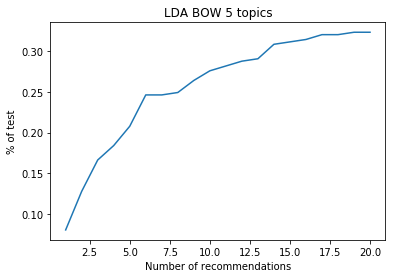

In [175]:
# trying 5 topics
df_doc_topic, df_doc_topic_test = create_model(bow_corpus, bow_corpus_test, 5)
elbow_graph(df_doc_topic)

topics = int(input())
lda_bow_5 = topic_acc_tourist(df_doc_topic, df_doc_topic_test, topics)

plt.plot(lda_bow_5['rank'], lda_bow_5['testinclusion'])
plt.title('LDA BOW 5 topics')
plt.xlabel('Number of recommendations')
plt.ylabel('% of test')
plt.show()

In [176]:
lda_bow_5

,rank,testinclusion
0,1.0,0.080119
1,2.0,0.127596
2,3.0,0.166172
3,4.0,0.183976
4,5.0,0.207715
5,6.0,0.246291
6,7.0,0.246291
7,8.0,0.249258
8,9.0,0.264095
9,10.0,0.275964
